- [Text Classification Using Flax (JAX) Networks](https://coderzcolumn.com/tutorials/artificial-intelligence/text-classification-using-flax-jax-networks)

# Concise Implementation of Linear Regression
:label:`sec_linear_concise`

Broad and intense interest in deep learning for the past several years
has inspired companies, academics, and hobbyists
to develop a variety of mature open source frameworks
for automating the repetitive work of implementing
gradient-based learning algorithms.
In :numref:`sec_linear_scratch`, we relied only on
(i) tensors for data storage and linear algebra;
and (ii) auto differentiation for calculating gradients.
In practice, because data iterators, loss functions, optimizers,
and neural network layers
are so common, modern libraries implement these components for us as well.

In this section, (**we will show you how to implement
the linear regression model**) from :numref:`sec_linear_scratch`
(**concisely by using high-level APIs**) of deep learning frameworks.


## Standard Imports

In [1]:
import d2l
import jax
from jax import numpy as jnp, random
import numpy as np
import optax
from tqdm import tqdm
print("Using jax", jax.__version__)
print("Optax Version : {}".format(optax.__version__))
jax.local_devices()

Using jax 0.3.13
Optax Version : 0.1.2


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Generating the Dataset

To start, we will generate the same dataset as in :numref:`sec_linear_scratch`.

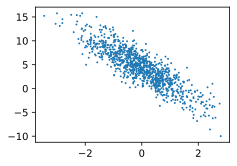

In [2]:
def synthetic_data(key, w, b, num_examples):
    """Generate y = Xw + b + noise."""
    key_sample, key_noise = random.split(key)
    X = random.normal(key_sample, (num_examples, len(w)))
    y = jnp.dot(X, w) + b
    y +=  0.01 * random.normal(key_noise, (len(y),))
    #return np.array(X), np.array(y)
    return X, y

initial_key = random.PRNGKey(0)
k1, k2 = random.split(initial_key)
 
true_w = jnp.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(k1, true_w, true_b, 1000)

d2l.set_figsize()
#d2l.plt.scatter(features[:,0], labels, s=1);
d2l.plt.scatter(features[:,1], labels, s=1);

## Reading the Dataset

Rather than rolling our own iterator,
we can [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


Now we can use `data_iter` in much the same way as we called
the `data_iter` function in :numref:`sec_linear_scratch`.
To verify that it is working, we can read and print
the first minibatch of examples.
Comparing with :numref:`sec_linear_scratch`,
here we use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.


In [ ]:
next(iter(data_iter))

## Defining the Model

When we implemented linear regression from scratch
in :numref:`sec_linear_scratch`,
we defined our model parameters explicitly
and coded up the calculations to produce output
using basic linear algebra operations.
You *should* know how to do this.
But once your models get more complex,
and once you have to do this nearly every day,
you will be glad for the assistance.
The situation is similar to coding up your own blog from scratch.
Doing it once or twice is rewarding and instructive,
but you would be a lousy web developer
if every time you needed a blog you spent a month
reinventing the wheel.

For standard operations, we can [**use a framework's predefined layers,**]
which allow us to focus especially
on the layers used to construct the model
rather than having to focus on the implementation.
We will first define a model variable `net`,
which will refer to an instance of the `Sequential` class.
The `Sequential` class defines a container
for several layers that will be chained together.
Given input data, a `Sequential` instance passes it through
the first layer, in turn passing the output
as the second layer's input and so forth.
In the following example, our model consists of only one layer,
so we do not really need `Sequential`.
But since nearly all of our future models
will involve multiple layers,
we will use it anyway just to familiarize you
with the most standard workflow.

Recall the architecture of a single-layer network as shown in :numref:`fig_single_neuron`.
The layer is said to be *fully-connected*
because each of its inputs is connected to each of its outputs
by means of a matrix-vector multiplication.


In PyTorch, the fully-connected layer is defined in the `Linear` class. Note that we passed two arguments into `nn.Linear`. The first one specifies the input feature dimension, which is 2, and the second one is the output feature dimension, which is a single scalar and therefore 1.


- [linen_intro](http://127.0.0.1:8080/notebooks/30-days-of-jax-on-tpu/flax-101/linen_intro.ipynb)

In [3]:
from flax import linen as nn

class LinearRegression(nn.Module):

    def setup(self): self.ll = nn.Dense(1)

    def __call__(self, inputs): return self.ll(inputs)

## Initializing Model Parameters

Before using `net`, we need to (**initialize the model parameters,**)
such as the weights and bias in the linear regression model.
Deep learning frameworks often have a predefined way to initialize the parameters.
Here we specify that each weight parameter
should be randomly sampled from a normal distribution
with mean 0 and standard deviation 0.01.
The bias parameter will be initialized to zero.


As we have specified the input and output dimensions when constructing `nn.Linear`,
now we can access the parameters directly to specify their initial values.
We first locate the layer by `net[0]`, which is the first layer in the network,
and then use the `weight.data` and `bias.data` methods to access the parameters.
Next we use the replace methods `normal_` and `fill_` to overwrite parameter values.


In [4]:
from flax.core import unfreeze

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4, 2))

net = LinearRegression()
params = net.init(key2, x)
y = net.apply(params, x)

print('initialized parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', y)

initialized parameter shapes:
 {'params': {'ll': {'bias': (1,), 'kernel': (2, 1)}}}
output:
 [[-0.43958804]
 [-0.06593186]
 [-0.11559814]
 [-0.3480543 ]]


## Defining the Loss Function


[**The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).**]
By default it returns the average loss over examples.


In [5]:
# Loss function: Mean squared error.
def mse(params, x_batched, y_batched):
    # Define the squared loss for a single pair (x,y)
    def squared_error(x, y):
        y_pred = net.apply(params, x)
        return jnp.inner(y-y_pred, y-y_pred) / 2.0
    # We vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched), axis=0)

## Defining the Optimization Algorithm


Minibatch stochastic gradient descent is a standard tool
for optimizing neural networks
and thus PyTorch supports it alongside a number of
variations on this algorithm in the `optim` module.
When we (**instantiate an `SGD` instance,**)
we will specify the parameters to optimize over
(obtainable from our net via `net.parameters()`), with a dictionary of hyperparameters
required by our optimization algorithm.
Minibatch stochastic gradient descent just requires that
we set the value `lr`, which is set to 0.03 here.


In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## Training

You might have noticed that expressing our model through
high-level APIs of a deep learning framework
requires comparatively few lines of code.
We did not have to individually allocate parameters,
define our loss function, or implement minibatch stochastic gradient descent.
Once we start working with much more complex models,
advantages of high-level APIs will grow considerably.
However, once we have all the basic pieces in place,
[**the training loop itself is strikingly similar
to what we did when implementing everything from scratch.**]

To refresh your memory: for some number of epochs,
we will make a complete pass over the dataset (`train_data`),
iteratively grabbing one minibatch of inputs
and the corresponding ground-truth labels.
For each minibatch, we go through the following ritual:

* Generate predictions by calling `net(X)` and calculate the loss `l` (the forward propagation).
* Calculate gradients by running the backpropagation.
* Update the model parameters by invoking our optimizer.

For good measure, we compute the loss after each epoch and print it to monitor progress.


In [6]:
def train(X, y, epochs, weights, optimizer_state, batch_size):
    for i in range(1, epochs + 1):
        batches = jnp.arange((X.shape[0]//batch_size)+1) ### Batch Indices
        for batch in tqdm(batches):
            if batch != batches[-1]:
                start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
            else:
                start, end = int(batch*batch_size), None

            X_batch, Y_batch = X[start:end], y[start:end] ## Single batch of data

            loss, gradients = loss_grad(weights, X_batch, Y_batch)

            ## Update Weights
            updates, optimizer_state = optimizer.update(gradients, optimizer_state)
            weights = optax.apply_updates(weights, updates)
    return weights

batch_size = 10
epochs=3
optimizer = optax.sgd(learning_rate=0.03) ## Initialize SGD Optimizer using OPTAX

optimizer_state = optimizer.init(params)
loss_grad = jax.value_and_grad(mse)

params = train(features, labels, epochs, params, optimizer_state, batch_size=batch_size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 30.98it/s]


Below, we [**compare the model parameters learned by training on finite data
and the actual parameters**] that generated our dataset.
To access parameters,
we first access the layer that we need from `net`
and then access that layer's weights and bias.
As in our from-scratch implementation,
note that our estimated parameters are
close to their ground-truth counterparts.


In [7]:
b, w = params['params']['ll']['bias'], params['params']['ll']['kernel'].T
print(f'error in estimating w: {true_w - w}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [[ 3.0052662e-04 -5.0783157e-05]]
error in estimating b: [0.00013876]


## Summary


* Using PyTorch's high-level APIs, we can implement models much more concisely.
* In PyTorch, the `data` module provides tools for data processing, the `nn` module defines a large number of neural network layers and common loss functions.
* We can initialize the parameters by replacing their values with methods ending with `_`.


## Exercises


1. If we replace `nn.MSELoss(reduction='sum')` with `nn.MSELoss()`, how can we change the learning rate for the code to behave identically. Why?
1. Review the PyTorch documentation to see what loss functions and initialization methods are provided. Replace the loss by Huber's loss.
1. How do you access the gradient of `net[0].weight`?

[Discussions](https://discuss.d2l.ai/t/45)
